<a href="https://colab.research.google.com/github/Saisha0512/Portfolio_Optimization_ML_DL/blob/main/Portfolio_Optimization_ML_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Problem Statement**

# **2. Data Collection**

In [12]:
# Installing the required libraries
!pip install pandas numpy matplotlib seaborn yfinance

In [13]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [14]:
!pip install yfinance

import yfinance as yf
import pandas as pd

# Define the ticker symbols
tickers = ['AGG', 'VTI', 'DBC', 'VIX']  # Use '^VIX' for the volatility index

# Set the time period
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download OHLCV data
data = {}
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    df.to_csv(f"{ticker}_historical_OHLCV_data.csv")
    data[ticker] = df

/tmp/ipython-input-1969910542.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1969910542.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1969910542.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1969910542.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [15]:
# Show sample data
data['AGG'].head()

Price,Close,High,Low,Open,Volume
Ticker,AGG,AGG,AGG,AGG,AGG
Date,,,,,
2015-01-02,83.327919,83.380739,83.139275,83.139275,2090200
2015-01-05,83.509056,83.576971,83.365690,83.426052,3446200
2015-01-06,83.720306,84.022138,83.675034,83.727854,3688100
2015-01-07,83.705254,83.788258,83.561882,83.758074,3984400
2015-01-08,83.576920,83.637281,83.478821,83.637281,2212200


# **3. Data Preprocessing**

In [16]:
# Reading all the CSV Files individually
agg = pd.read_csv("AGG_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
vti = pd.read_csv("VTI_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
dbc = pd.read_csv("DBC_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
vix = pd.read_csv("VIX_historical_OHLCV_data.csv", index_col=0, parse_dates=True)

/tmp/ipython-input-3028564036.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  agg = pd.read_csv("AGG_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
/tmp/ipython-input-3028564036.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  vti = pd.read_csv("VTI_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
/tmp/ipython-input-3028564036.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dbc = pd.read_csv("DBC_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
/tmp/ipython-input-3028564036.py:5: UserWarning: Could not infer format, so each element

In [23]:
# Preprocessing Function for Each Asset
def preprocess_asset(df, asset_name):
    df = df.copy()

    # Convert relevant columns to numeric (errors='coerce' converts non-numeric to NaN)
    cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Fill missing values
    df = df.ffill().bfill()

    # Sort by datetime
    df = df.sort_index()

    # Calculate features using 'Close'
    df['Daily Return'] = df['Close'].pct_change()
    df['Cumulative Return'] = (1 + df['Daily Return']).cumprod()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['Rolling Volatility'] = df['Daily Return'].rolling(window=30).std() * np.sqrt(252)

    # Add prefix to all columns
    df = df.add_prefix(f'{asset_name}_')

    return df

In [24]:
# Apply Preprocessing to Each Asset
agg_clean = preprocess_asset(agg, 'AGG')
vti_clean = preprocess_asset(vti, 'VTI')
dbc_clean = preprocess_asset(dbc, 'DBC')
vix_clean = preprocess_asset(vix, 'VIX')

# **4. EDA**

                  AGG        DBC    VIX        VTI
Date                                              
03-04-2006  98.599998  24.049999  11.57  64.764999
04-04-2006  98.730003  23.920000  11.14  65.139999
05-04-2006  98.800003  24.070000  11.13  65.379997
06-04-2006  98.720001  24.500000  11.45  65.349998
07-04-2006  98.389999  24.389999  12.26  64.650002


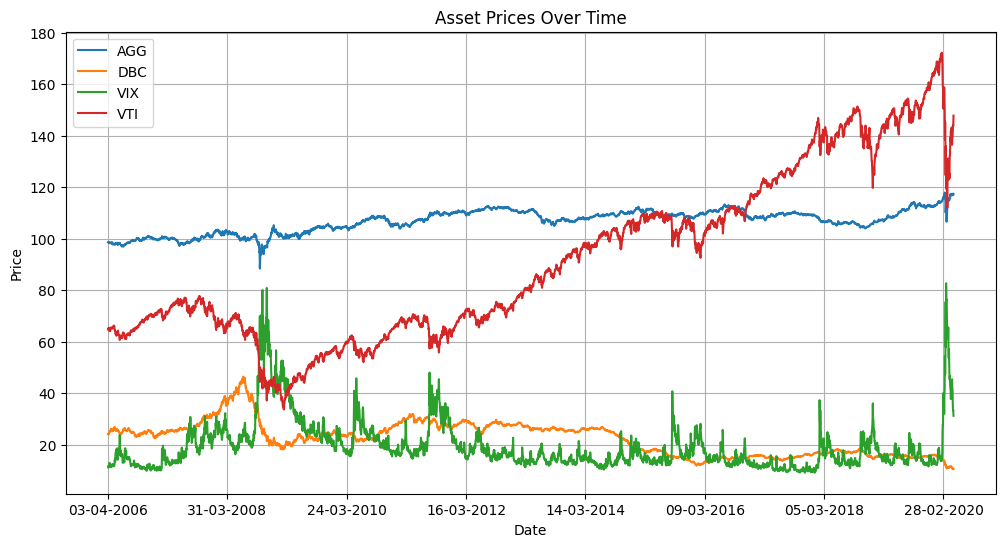

In [ ]:
# Combining Closing Prices into one Dataframe (for simplicity)
assets = pd.DataFrame({
    "AGG": agg["Close"],
    "DBC": dbc["Close"],
    "VIX": vix["Close"],
    "VTI": vti["Close"]
})

# Dropping missing values
assets = assets.dropna()

# Viewing the final data
print(assets.head())
assets.plot(title="Asset Prices Over Time", figsize=(12, 6))
plt.ylabel("Price")
plt.grid(True)
plt.show()

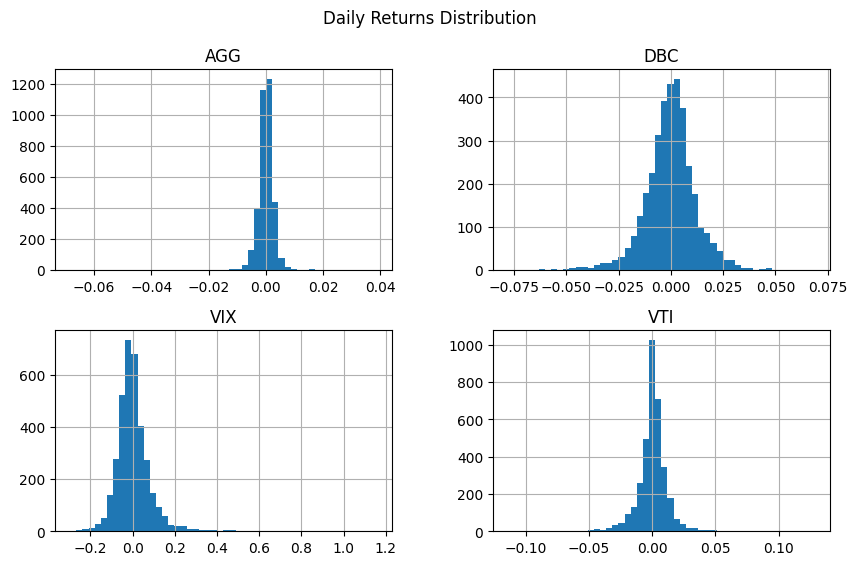

In [ ]:
# Calculating Daily Return

# Return = % change from previous day
returns = assets.pct_change().dropna()
returns.head()

# Visualizing Histogram for Return
returns.hist(figsize=(10, 6), bins=50)
plt.suptitle("Daily Returns Distribution")
plt.show()

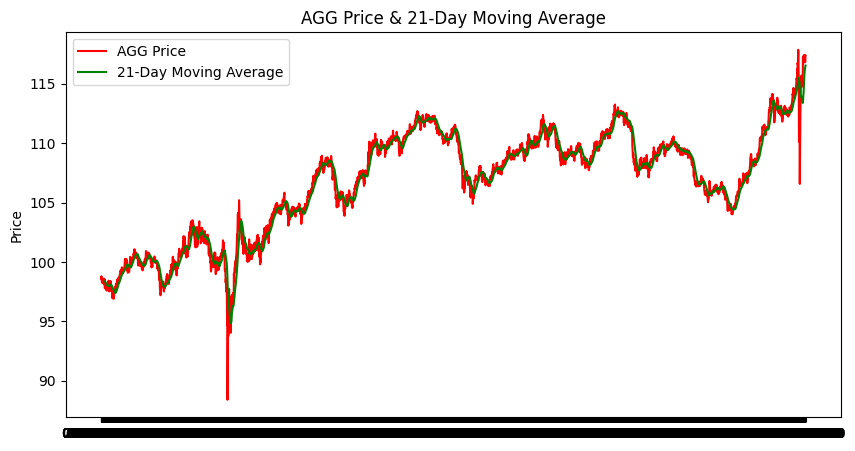

In [ ]:
# Calculating Volatality and Moving Averages

# 21-day rolling volatility and moving average
volatility = returns.rolling(window=21).std()
moving_avg = assets.rolling(window=21).mean()

# Plot AGG moving average vs price
plt.figure(figsize=(10, 5))
plt.plot(assets["AGG"], label="AGG Price", color = 'red')
plt.plot(moving_avg["AGG"], label="21-Day Moving Average", color = 'green')
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.title("AGG Price & 21-Day Moving Average")
plt.show()

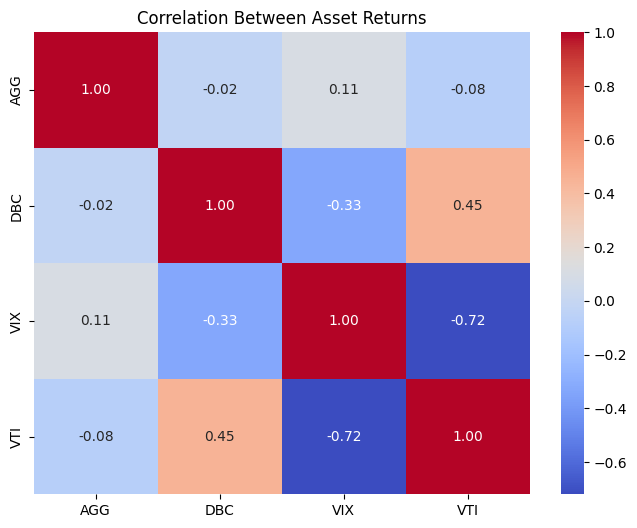

In [ ]:
# Plotting Correlation Matrix for Analysis
corr_mat = returns.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Asset Returns")
plt.show()

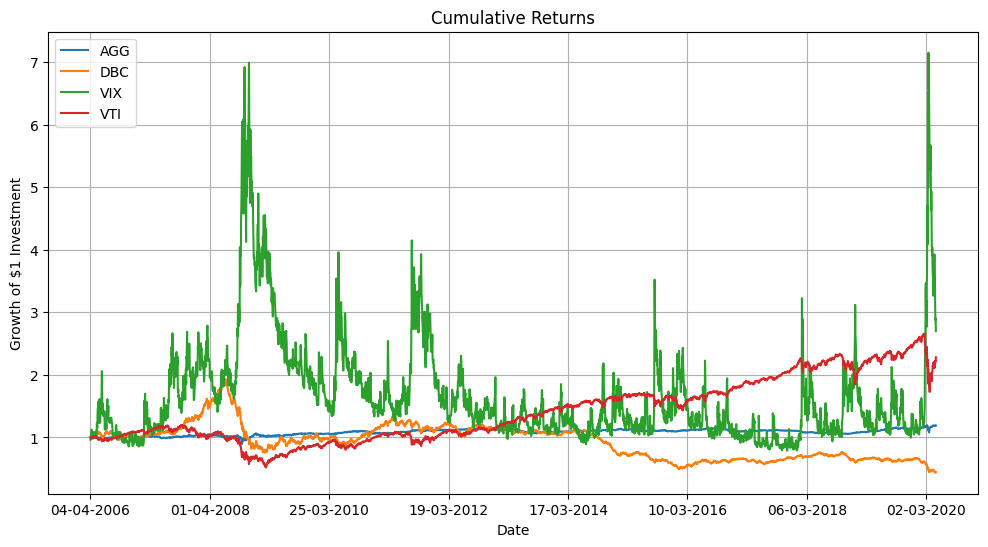

In [ ]:
# Visaulizing Cumulative Returns
cumulative_returns = (1 + returns).cumprod()

# Plot
cumulative_returns.plot(figsize=(12, 6), title="Cumulative Returns")
plt.grid(True)
plt.ylabel("Growth of $1 Investment")
plt.show()

# **5. Feature Engineering**